In [73]:
import plotly.express as px
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import CalculatedFieldSubroutines as cfs

In [74]:
cols = [
    "drivingMode",
    "BinaryDrivingMode",
    "TernaryDrivingModeTransition",
    "time_x",
    "time_sec",
    "speedMps",
    "throttlePercentage",
    "brakePercentage",
    "steeringPercentage",
    "steeringRate",
    "numSatsInSolution",
    "LatLonTotalStdDev",
    "latitude",
    "longitude",
    "differentialAge",
    "time_y",
]

In [75]:
gmID = "a253145a-d2a6-11ee-b437-336917683bb8"
#gmID = "2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4"

In [76]:
chassis_df = pd.read_csv(f"./data/chassis/{gmID}.csv")
best_pose_df = pd.read_csv(f"./data/best_pose/{gmID}.csv")

chassis_df = chassis_df.sort_values(by="time")
best_pose_df = best_pose_df.sort_values(by="time")

chassis_df.reset_index(drop=True,inplace=True)
best_pose_df.reset_index(drop=True,inplace=True)

In [77]:
cfs.ChassisBestPoseMatchedTime(chassis_df,best_pose_df)

merged_df = pd.merge(chassis_df,best_pose_df,on="ChassisBestPoseMatchedTime")

merged_df = merged_df.drop_duplicates(subset=['latitude', "longitude","drivingMode"])

cfs.BinaryDrivingMode(merged_df)
cfs.TernaryDrivingModeTransition(merged_df)
cfs.LatLonTotalStdDev(merged_df)

merged_df['time_sec'] = merged_df['time_x'].astype('datetime64[ns]')
merged_df['time_sec'] = merged_df['time_sec'].astype('datetime64[s]')

best_pose_df['time_sec'] = best_pose_df['time'].astype('datetime64[ns]')
best_pose_df['time_sec'] = best_pose_df['time_sec'].astype('datetime64[s]')

chassis_df['time_sec'] = chassis_df['time'].astype('datetime64[ns]')
chassis_df['time_sec'] = chassis_df['time_sec'].astype('datetime64[s]')

merged_df["drivingMode"] = np.where(merged_df["drivingMode"]  == "EMERGENCY_MODE", "COMPLETE_MANUAL",merged_df["drivingMode"])
#print(best_pose_df['header.sequenceNum'])

merged_df.reset_index(drop=True,inplace=True)
merged_df['index'] = merged_df.index


merged_df.shape

(2182, 50)

### Segmentation

In [78]:
merged_df['distance (m)'] = (merged_df['speedMps'] * (merged_df['time_y'].diff()/1000000000).fillna(0)).cumsum()
merged_df['distance (m)']

0           0.000000
1           0.960238
2           1.671111
3           2.456242
4           2.850693
            ...     
2177    21519.093011
2178    21530.631316
2179    21541.742818
2180    21552.570345
2181    21562.937087
Name: distance (m), Length: 2182, dtype: float64

#### disengagements

In [79]:
# Identify disengagement points (for example, when speed is 0)
disengagement_indices = merged_df[merged_df['TernaryDrivingModeTransition'] == -1].index.tolist()

m_range = 100 #number of meters 

# Segment data by 50 meters prior to each disengagement
disengagement_segments = []
for disengagement_index in disengagement_indices:
    disengagement_distance = merged_df.at[disengagement_index, 'distance (m)']
    start_distance = disengagement_distance - m_range
    
    print(f"{start_distance}m -> {disengagement_distance}m")

    # Get the indices for the segment
    segment = merged_df[(merged_df['distance (m)'] >= start_distance) & (merged_df['distance (m)'] <= disengagement_distance)]
    disengagement_segments.append(segment.index)

# Display the segments
#for i, segment in enumerate(segments):
#    print(f"Segment {i + 1}:\n{segment}\n")

1421.8265286890312m -> 1521.8265286890312m
2616.131872598213m -> 2716.131872598213m
9330.748638977177m -> 9430.748638977177m
9860.868300944841m -> 9960.868300944841m
10861.554649012327m -> 10961.554649012327m
11570.067886429217m -> 11670.067886429217m
12576.763514542192m -> 12676.763514542192m
15368.733724633577m -> 15468.733724633577m
15933.879846341119m -> 16033.879846341119m
17272.731738567407m -> 17372.731738567407m
17814.585273454m -> 17914.585273454m
20862.411161403783m -> 20962.411161403783m


In [80]:
indicies = pd.DataFrame()
for i, segment in enumerate(disengagement_segments):
    
    temp = pd.DataFrame(segment)
    
    indicies = pd.concat([indicies, temp])
    
indicies
    

,0
0,289
1,290
2,291
3,292
4,293
...,...
5,2101
6,2102
7,2103
8,2104


In [81]:
# Define your map with your dataframe name first and keep everything else the same
fig2 = px.scatter_mapbox(merged_df.iloc[indicies[0]], 
                        lat="latitude",
                        lon="longitude",
                        hover_data=["time_x", "header.sequenceNum", "index","distance (m)"],
                        color="drivingMode",
                        zoom=12,
                        height=900,
                        width=700,
                        color_discrete_map={
                            "COMPLETE_MANUAL": "#601A4A",
                            "COMPLETE_AUTO_DRIVE": "#63ACBE",
                            "EMERGENCY_MODE": "#EE442F",
                        }
                        #color_discrete_map={
                        #    "0": "#EE442F",
                        #    "1": "#63ACBE",
                        #}

                        )

# Layout settings
fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig2.update_traces(marker=dict(size=8,opacity=1))


# Display the map
fig2.show()

#### reengagements

In [82]:
# Identify disengagement points (for example, when speed is 0)
reengagement_indices = merged_df[merged_df['TernaryDrivingModeTransition'] == 1].index.tolist()

m_range = 100 #number of meters 

# Segment data by 50 meters prior to each disengagement
reengagement_segments = []
for reengagement_index in reengagement_indices:
    reengagement_distance = merged_df.at[reengagement_index, 'distance (m)']
    start_distance = reengagement_distance - m_range
    
    print(f"{start_distance}m -> {reengagement_distance}m")

    # Get the indices for the segment
    segment = merged_df[(merged_df['distance (m)'] >= start_distance) & (merged_df['distance (m)'] <= reengagement_distance)]
    reengagement_segments.append(segment.index)

# Display the segments
#for i, segment in enumerate(segments):
#    print(f"Segment {i + 1}:\n{segment}\n")

1118.5339010306002m -> 1218.5339010306002m
1493.377809302244m -> 1593.377809302244m
3101.337695337676m -> 3201.337695337676m
9400.551456225265m -> 9500.551456225265m
10081.541240976603m -> 10181.541240976603m
10928.328368089324m -> 11028.328368089324m
12044.047981533986m -> 12144.047981533986m
12709.461877775215m -> 12809.461877775215m
15630.505269719217m -> 15730.505269719217m
16251.38427465873m -> 16351.38427465873m
17439.956549951617m -> 17539.956549951617m
18401.539539934358m -> 18501.539539934358m


In [83]:
indicies = pd.DataFrame()
for i, segment in enumerate(reengagement_segments):
    
    temp = pd.DataFrame(segment)
    
    indicies = pd.concat([indicies, temp])
    
indicies
    

,0
0,253
1,254
2,255
3,256
4,257
...,...
4,1896
5,1897
6,1898
7,1899


In [84]:
# Define your map with your dataframe name first and keep everything else the same

fig2 = px.scatter_mapbox(merged_df.iloc[indicies[0]], 
                        lat="latitude",
                        lon="longitude",
                        hover_data=["time_x", "header.sequenceNum", "index","distance (m)"],
                        color="drivingMode",
                        zoom=12,
                                                height=900,

                        width=700,
                        color_discrete_map={
                            "COMPLETE_MANUAL": "#601A4A",
                            "COMPLETE_AUTO_DRIVE": "#63ACBE",
                            "EMERGENCY_MODE": "#EE442F",
                        }
                        #color_discrete_map={
                        #    "0": "#EE442F",
                        #    "1": "#63ACBE",
                        #}

                        )

# Layout settings
fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

fig2.update_traces(marker=dict(size=8,opacity=1))


# Display the map
fig2.show()

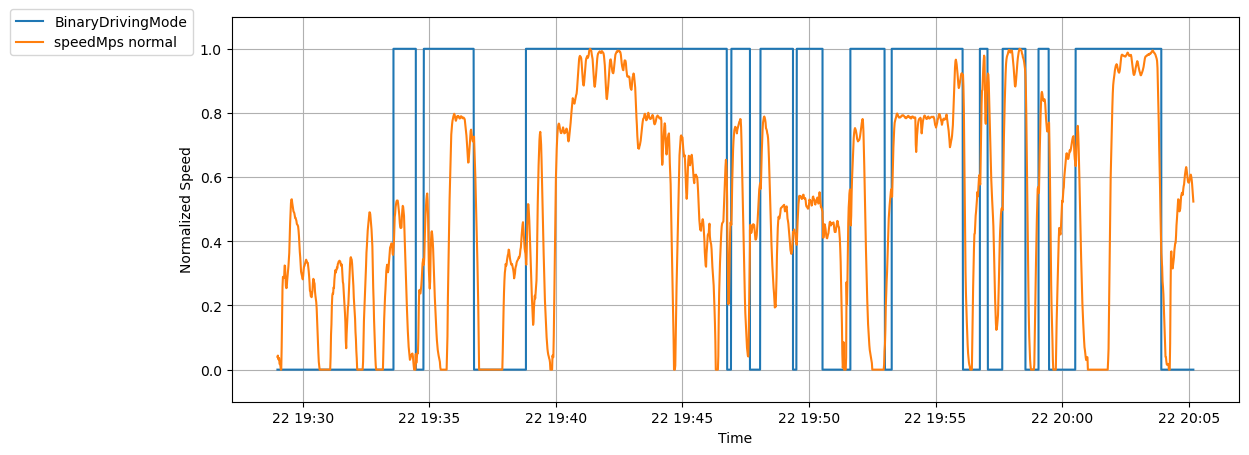

In [85]:
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(13, 5))
#plt.plot(merged_df['time_sec'], merged_df["BinaryDrivingMode"], label='BinaryDrivingMode')
#plt.plot(merged_df['time_sec'], merged_df["speedMps"], label='speedMps')

scaler = MinMaxScaler()
merged_df["speedMps, normal"] = scaler.fit_transform(merged_df[["speedMps"]])

plt.plot(merged_df['time_sec'], merged_df["BinaryDrivingMode"], label='BinaryDrivingMode')
plt.plot(merged_df['time_sec'], merged_df["speedMps, normal"], label='speedMps normal')

# Adding titles and labels
plt.xlabel('Time')
plt.ylabel('Normalized Speed')
plt.ylim(-0.1, 1.1)  # Set y limits to include binary data clearly
plt.grid(True)
plt.legend(loc=(-.22,.9))
plt.show()